In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 30 13:31:56 2023

@author: rum

Changed the way we truncate the matrices to be more pythonic. 
TO DO: fix regression script.
Input: Text files / folders with the named text files for the region. 
Output: Figures and folders with linear regressions

ADAPTED from Tiffany Andersos AA_ST_smooth_MAIN.m' matlab script. 
This script calculates rates and intercepts using ST
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#from AA_ST_regression_Python import AAA_ST_regress
from AA_ST_regression_Python import *
from make_smooth_mat_python import *



In [2]:


# BEGINNING OF USER INPUT AREA
flag_df_one_add_one = True
# flag_df_one_add_one = False  # Use this for Kauai...

region = 'EOahu'

savefig = True
# savefig = False

# END OF USER INPUT AREA
# ----------------------------------------------------------------------
m2ft = 3.28084  # conversion factor for meters to feet

# make directory called '<region>_results' if it does not exist
if not os.path.isdir(f"{region}_results"):
    os.mkdir(f"{region}_results")

# make directory called 'Figs' in existing dir '<region>_results'
# if it does not exist
if not os.path.isdir(f"{region}_results\Figs"):
    os.mkdir(f"{region}_results\Figs")

# Define directory name and full filename where section file is located
regiondirname = f"{os.getcwd()}\{region}_dat\\"
sectfilename = f"{region}_sections.txt"
sectfile = f"{regiondirname}{sectfilename}"
sects = np.loadtxt(sectfile, dtype=str)

results_all = {}



In [3]:

for sectname in sects[0:1]:
    print(f"Processing {sectname}...")
    # Define directory name and full filename where data file is located
    dirname = f"{regiondirname}{sectname}_dat\\"
    modelname = f"{sectname}Toedist.txt"
    datfile = f"{dirname}{modelname}"

    # Define full filename of truncation file (identifies hardened shorelines)
    truncname = f"{sectname}Truncation.txt"
    truncfile = f"{dirname}{truncname}"

    # Define full filename of boundary file (identifies alongshore breaks in continuity)
    boundname = f"{sectname}Boundary.txt"
    boundfile = f"{dirname}{boundname}"

    # Define directory name and full filename where veg line data file is located
    vegname = f"{sectname}Vegdist.txt"
    vegfile = f"{dirname}{vegname}"

    # ---------------------------
    # load data, veg, boundary, and truncation files
    data_raw = pd.read_csv(datfile, sep="\t", header=None).to_numpy()
    full = np.copy(data_raw)
    full_flat = np.copy(data_raw)
    
    trunc = pd.read_csv(truncfile, sep="\t", header=None).to_numpy().astype(np.int16)
    #trunc = np.loadtxt(truncfile).astype(np.int16)
    bounds = np.loadtxt(boundfile)
    veg_raw = np.loadtxt(vegfile)

    if data_raw.size == 0:
        raise ValueError("Data file is empty. Please check file format. Text MS-DOS works.")
    if bounds.size == 0:
        raise ValueError("Boundary file is empty. Please do not use 'NaN' - define entire boundary.")
    if np.isnan(bounds).any():
        raise ValueError("Please do not use 'NaN' - define one boundary instead.")
    if trunc.size == 0:
        raise ValueError("Truncation file is empty. If no truncation, please use 'NaN'")
    if veg_raw.size == 0:
        raise ValueError("Veg dist file is empty. Please check file format. Text MS-DOS works.")
    #if not (veg_raw[0, 1:-1] == data_raw[0 , 1:-1]).all():
    if (veg_raw[2:, 0] == data_raw[2:, 0]).min() == False: ## ABM edit. dumb wait to fix it
        print((veg_raw[2:, 0] == data_raw[2:, 0]).min())
        raise ValueError("Different number of survey dates in vegdist and toedist file. Please check data.")
    if not (veg_raw[2:, 0] == data_raw[2:, 0]).all():
        raise ValueError("Different number of transects in vegdist and toedist file. Please check data.")
    if not np.allclose(veg_raw[0, 1:], data_raw[0, 1:]):
        raise ValueError("Dates in veg dist file do not match those in toedist. Please check data.")
    if not (veg_raw[2:, 0] <= data_raw[2:, 0]).all():
        raise ValueError("Transect numbers in veg dist file do not match those in toedist. Please check data.")

    # define time series segments, years
    t_data = data_raw[0, 1:]
          
    # put truncated values in matrix for plotting later. initialize matrices. 
    hardshore_data = np.full_like(full, np.nan)                  ## ALL NANs?    #All nans except col_end value, and Nan'd values (full)
    truncated_data = np.full_like(full, np.nan)                  ## ALL NANs?    #All nans except Nan'd values (full)
    hardshore_data_flat = np.full_like(full, np.nan)             ## ALL NANs?    #All nans except col_end value, and Nan'd values  (full_flat)
    hardshore_data_flat_truncated = np.full_like(full, np.nan)   ## ALL NANs?    #All nans except Nan'd values (full_flat)
        
    
    ## Check that truncation inds are not just NaN, if so skip that file. No truncation
    if np.product(trunc.shape) == 1 or trunc.flatten()[0] is np.nan:  ### ABM edit from AND to OR 
        
        #raise ValueError("Nothing to truncate")
        print(f"SKIPPING {sectname}... trunc file empty")
        continue # Skip to next elt in the loop
    
    ## Convert truncation inds to python (from matlab, columns index would start at 1)
    trunc[:, 2] -= 1 ###ABM double check if we need to channge ending index tooo
    #### ABM: do we need to add +1 to the ending transect indices since the end is not inlcuded
    
    # Based on truncation file, remove duplicate data due to seawall 
    # construction or other hard structure by setting those data to NaN 
    # NOTE: This does not change the size of the matrix (doesn't remove 
    # any rows or columns), it only replaces the duplicate data with NaNs or flattens it to the value in [row,col_end]
    
    for trans_start, trans_end, col_start, col_end in trunc:
        # Note that trans end is inclusive, but col end is not
        
        row_start = np.where(full[:, 0] == trans_start)[0][0]  # find the row index that matches the trans_start
        row_end = np.where(full[:, 0] == trans_end)[0][0] + 1  # find the row index that matches the trans_end + 1 (because need inclusivity)
        
        ## Since the first column (transect number) needs to be ignored
        col_start += 1 # We don't actually need column start at all!? It seems trunc file ALWAYS has third column starting at index 1 (to keep)
        col_end_og = col_end
        col_end += 1 
        
        #keep_cols = range(col_start,col_end,1)
        ## Fill data
        
        #record data matrices 
        hardshore_data[row_start:row_end, col_end-1:] = full[row_start:row_end, col_end-1:]
        truncated_data[row_start:row_end, col_end:] = full[row_start:row_end, col_end:]
    
        #change the data table copies
        full[row_start:row_end, col_end:] = np.nan #if assuming third column is always 1, this is same as data_trunc
        
        full_flat[row_start:row_end, col_end:] = full[row_start:row_end, col_end-1].reshape((row_end-row_start, 1)) 
        
        #record second pair of data matrices
        hardshore_data_flat[row_start:row_end, col_end-1:] = full_flat[row_start:row_end, col_end-1:]
        hardshore_data_flat_truncated[row_start:row_end, col_end:] = full_flat[row_start:row_end, col_end:]
        
    
    #slice off the row with the dates and the column with the transect numbers.     
    hardshore_data = hardshore_data[2:,1:]
    truncated_data = truncated_data[2:,1:]
    hardshore_data_flat = hardshore_data_flat[2:,1:]
    hardshore_data_flat_truncated = hardshore_data_flat_truncated[2:,1:]


    ### END TRUNCATION SHIT, START REGRESSION
    #### WORKS TO HERE 


Processing Hauula...


In [ ]:
######## END of MAIN script when regressoin works

    # perform ST regression
    ST_sect, ST_sect_figs = AAA_ST_regress(full, bounds, flag_df_one_add_one)
    ST_sect['truncated_data_m'] = truncated_data
    ST_sect['truncated_data_ft'] = truncated_data * m2ft
    ST_sect['hardshore_data_m'] = hardshore_data
    ST_sect['hardshore_data_ft'] = hardshore_data * m2ft
    ST_sect['hardshore_data_flat_m'] = hardshore_data_flat
    ST_sect['hardshore_data_flat_ft'] = hardshore_data_flat * m2ft
    ST_sect['hardshore_data_flat_truncated_m'] = hardshore_data_flat_truncated
    ST_sect['hardshore_data_flat_truncated_ft'] = hardshore_data_flat_truncated * m2ft

    if savefig:
        # save figures of data and parameters
        plt.figure(ST_sect_figs['data_METERS'])
        plt.savefig(f"{region}_results\Figs\{sectname}_{int(t_data[0])}_{int(t_data[-1])}_data_METERS.png")

        plt.figure(ST_sect_figs['params_METERS'])
        plt.savefig(f"{region}_results\Figs\{sectname}_{int(t_data[0])}_{int(t_data[-1])}_params_METERS.png")

        plt.figure(ST_sect_figs['data_FEET'])
        plt.savefig(f"{region}_results\Figs\{sectname}_{int(t_data[0])}_{int(t_data[-1])}_data_FEET.png")

        plt.figure(ST_sect_figs['params_FEET'])
        plt.savefig(f"{region}_results\Figs\{sectname}_{int(t_data[0])}_{int(t_data[-1])}_params_FEET.png")

    plt.close(ST_sect_figs['data_METERS'])
    plt.close(ST_sect_figs['params_METERS'])
    plt.close(ST_sect_figs['data_FEET'])
    plt.close(ST_sect_figs['params_FEET'])

    results_area = {
        'name': sectname,
        'ST': ST_sect,
        'dates': t_data.tolist(),
        'data_raw': data_raw.tolist(),
        'veg_raw': veg_raw.tolist()
    }

    results_all[sectname] = results_area

    # save workspace
    np.save(f"{region}_results\workspace_{sectname}", results_area)

np.save(f"{region}_results\workspace_ALL", results_all)
np.save(f"{region}_results\AA_results_all", results_all)

print(f"Pau: {region} rates.")

In [ ]:
ST_sect, ST_sect_figs = AAA_ST_regress(full, bounds, flag_df_one_add_one)


In [4]:
# -*- coding: utf-8 -*-
# REGRESSION SCRIPT
"""
Created on Fri Dec  1 17:40:07 2023

@author: rum
"""
import sys
import os
sys.path.append(os.getcwd())

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp #csr_matrix
import scipy.linalg as la #, block_diag #, sqrtm, toeplitz, inv
from scipy.linalg import block_diag, toeplitz
from scipy.sparse.linalg import inv, spsolve
from scipy.stats import t
from make_smooth_mat_python import make_smooth_mat


In [ ]:
pd.DataFrame(full[:10,:10])

In [5]:
data_orig, bounds, flag_df_one_add_one = full, bounds, flag_df_one_add_one

m2ft = 3.28084  # conversion factor for meters to feet

# Determine transects with < three data points

crap_tr_inds = np.where(np.sum(~np.isnan(data_orig[2:, 1:]), axis=1) < 3)[0]
good_tr_inds = np.arange(data_orig.shape[0] - 2)
good_tr_inds = np.delete(good_tr_inds, crap_tr_inds)

if len(crap_tr_inds) == 0:
    data_orig_cond = data_orig
else:
    data_orig_cond = np.delete(data_orig, crap_tr_inds + 2, axis=0)

# Define distances between transects
dx_tr = 20; #meters

# Define some variables from data input

x_data = data_orig_cond[2: , 0] #transect numbers (starts with 0 in python?)
x_dist = np.array(x_data+1)*dx_tr  #convert transect numbers to distances;first transect is 20m, 2nd is 40m, etc
y_data = data_orig_cond[2:,1:] #shoreline positions (m) (distance from baseline)
t_data = data_orig_cond[0,1:] #survey times (year)
I = len(x_data) #number of transects (spatial)
J = len(t_data) #number of surveys (time)
m_err = np.tile(data_orig_cond[1, 1:], (I, 1)) #put measurement errors in matrix m_err. represents main diagonal. repeated values of the errors. 


# Create initial data covariance matrix
# (diagonal sparse matrix of squared measurement errors)
# Cd_orig = sp.diags(np.reshape(m_err**2, (J*I,1)), offsets=0) #shape should be square. squared unc for each time, repeated for the number of transect. large!
Cd_orig = sp.diags((m_err**2).flatten(order='F'), 0, format='csc')
Cd_inv_orig = sp.linalg.inv(Cd_orig) # invert the square matrix. (* basically 1/x_i where x_i is each diagonal value)
Cd_orig_half_sparse = np.sqrt(Cd_orig.data) ## hhmm this is the samen as m_err flattened (reshaped to J*I)

# Cd_orig_csc = Cd_orig.tocsc()            # formatting, compression
# Cd_inv_orig = sp.linalg.inv(Cd_orig_csc) # invert the square matrix. (* basically 1/x_i where x_i is each diagonal value)
# Cd_orig_half_sparse = np.sqrt(Cd_orig_csc.data) ## hhmm this is the samen as m_err flattened (reshaped to J*I)


In [6]:
# Calculate rates and parameters using ST method

# Determine weighted mean of times for each transect
m_err2_mat_zero = 1 / (m_err ** 2)  # calculate each err^(-2). ** weighted; high errors==low values here == low weight
m_err2_mat_zero[np.isnan(y_data)] = 0  # set to zero where there is no data
t_weighted_means = (m_err2_mat_zero @ t_data) / (np.sum(m_err2_mat_zero, axis=1)) ## Remove sum 

# define time and data arrays (with and without NaN data values)
t_data_mat = np.tile(t_data, (I, 1)) #t_data.reshape(1, -1)
t_data_mat_demean = t_data_mat - np.tile(t_weighted_means[:, np.newaxis], (1, J))
# t_data_mat_demean = t_data_mat - t_weighted_means ### I am not sure this is correct... shapes didnt match
d_orig = y_data.T.reshape(J * I, 1) 
# nan_inds = np.isnan(d_orig) # all the Nans are no measurement for any transect or any time 
nan_inds = np.where(np.isnan(d_orig))[0]
d_mod = np.delete(d_orig, nan_inds, axis=0)
# d_mod = d_orig[~nan_inds]
N = len(d_mod)  # number of total data points



In [7]:

# Assuming G_orig, nan_inds, Cd_orig are defined earlier

# Define system matrix (includes NaN data)
i = np.arange(0, len(d_orig)).T # values 1 to len(d_orig) (1572). shape: e.g. (1572,)
j = np.tile(np.arange(0, I), J) # shape: e.g. (1572,) 
sp_ = np.reshape(t_data_mat_demean.T, (J * I)) # shape: e.g. (1572,)
# G_r = sp.coo_matrix((sp_.flatten, (i, j)), shape=(len(d_orig), I))  # system matrix (portion) for rate only
G_r = sp.coo_matrix((sp_, (i, j))).T # system matrix (portion) for rate only.  ## changed index to start at 0, otherwise off
G_r = G_r.tocsr().T
G_i = sp.coo_matrix((np.ones_like(sp_), (i, j)), shape=(len(d_orig), I)) # system matrix (portion) for intercept only
G_i = G_i.tocsr()
G_orig = sp.hstack([G_r, G_i])  # complete system matrix for rate and intercept

# Remove rows in the system matrix and covariance matrix where data is nan
G_mod = G_orig.copy()  # set G_mod (G model) by removing rows/cols for missing data
G_mod_array = np.delete(G_mod.toarray(), nan_inds.tolist(), axis=0)
G_mod = sp.csr_matrix(G_mod_array).tocsc()

Cd0_mod = Cd_orig.copy()  # set Cd0_mod (Cd- model) by removing rows/cols for missing data
Cd0_mod_array = np.delete(Cd0_mod.toarray(), nan_inds.tolist(), axis=0)
Cd0_mod_array = np.delete(Cd0_mod_array, nan_inds.tolist(), axis=1)
Cd0_mod = sp.csr_matrix(Cd0_mod_array).tocsc()
Cd0_mod_inv = inv(Cd0_mod)


In [18]:

# Assuming G_mod, Cd0_mod, d_mod, m_err are defined earlier

# Invert for ST rates and intercepts
# m_ST = np.linalg.lstsq((G_mod.T @ Cd0_mod_inv @ G_mod).toarray(), G_mod.T @ Cd0_mod_inv @ d_mod, rcond=None)[0]
G_modT = G_mod.transpose(copy=True).tocsc()

m_ST = spsolve((G_modT @ Cd0_mod_inv @ G_mod), (G_modT @ Cd0_mod_inv @ d_mod))

ST_r = m_ST[:I] # for regression
ST_int = m_ST[I:] # for intercept
ST_y = np.reshape((G_orig @ m_ST), (J,I)).T  # make predictions for dates where no data exist (NaNs)
ST_res = y_data - ST_y  # when subtracting NaNs, will be NaN.

# Compute covariance scaling factor (alpha)
STi = np.reshape(np.repeat(np.arange(0, I), J), (I * J)) # shape (1572)
STj = np.arange(0, I*J) # shape (1572,)
STs = np.reshape(ST_res, (I * J)) # shape (1572,)
ST_tr = sp.csr_matrix((STs, (STi, STj))).T#, shape=(I * J, I)) # shape(1572,131)
ST_tr = ST_tr.T.tocsr()
CSTtr = sp.diags(np.reshape(m_err**2, I*J), 0, (I*J, I*J))
remove_nan = np.isnan(np.reshape(ST_res, I*J))

ST_tr = ST_tr[:, ~remove_nan]
CSTtr_lil = sp.lil_matrix(CSTtr)
CSTtr_lil = CSTtr_lil[~remove_nan.ravel(), :]
CSTtr = CSTtr_lil[:, ~remove_nan.ravel()].tocsc()
alpha_df = np.sum(~np.isnan(ST_res), axis=1) - 2  # degrees of freedom used to calculate alpha

if flag_df_one_add_one:  # if alpha == 1 (three shorelines), add one degree of freedom
    alpha_one = (alpha_df == 1)
    alpha_df[alpha_one] = 2
    if np.sum(alpha_one) > 0:
        print(f"Adding degree of freedom to Transects: {x_data[alpha_one]}")
ST_alpha = (ST_tr @ inv(CSTtr) @ ST_tr.T).diagonal() / alpha_df
alpha_zero = np.where(alpha_df < 1)[0]  # find df == 0 (only 2 shorelines)
# ST_alpha[alpha_zero] = ST_alpha[alpha_zero - 1]  # Set this alpha to the one next to it.
# ST_alpha[alpha_zero] = np.nan  # set the alpha with zero df to nan because it will be infinity (can't divide by zero)
# ST_alpha[alpha_zero] = np.nanmean(ST_alpha)  # use the mean of alphas in this section as the alpha value for statistical calculations


In [ ]:
pd.DataFrame(ST_y_var)

In [ ]:
ST_y_var = np.reshape(ST_var, (J,I)).T


In [13]:


# Assuming Cd_orig, ST_alpha, G_mod are defined earlier

# Define new scaled data covariance matrix
Cd_hat = sp.diags(np.tile(ST_alpha, J), 0, (J*I, J*I)) @ Cd_orig
Cd_hat_array = np.delete(Cd_hat.toarray(), nan_inds.tolist(), axis=0)
Cd_hat_array = np.delete(Cd_hat_array, nan_inds.tolist(), axis=1)
Cd_hat = sp.csc_matrix(Cd_hat_array).tocsc()
Cd_hat_inv = inv(Cd_hat.tocsc())


# Cd_hat = sp.diags(np.tile(ST_alpha, J), 0, (J*I, J*I)) @ Cd_orig
# Cd_hat_lil = sp.lil_matrix(Cd_hat)
# Cd_hat_lil[nan_inds.ravel(), :] = []
# Cd_hat_lil[:, nan_inds.ravel()] = []
# Cd_hat.tocsc()
# Cd_hat_inv = inv(Cd_hat)
# ST model covariance matrix
ST_Cm = inv(G_modT @ Cd_hat_inv @ G_mod)

# ST rate and intercept variances
ST_r_var = (ST_Cm[:I, :I]).diagonal()
ST_int_var = (ST_Cm[I:, I:]).diagonal()

# ST position prediction variance
ST_var = (G_orig @ ST_Cm @ G_orig.T).diagonal()
ST_y_var = np.reshape(ST_var, (J,I)).T

# Number of data (shoreline positions) per transect used in regression
ST_ndat = np.sum(~np.isnan(y_data), axis=1)

# Student's t-distribution
ST_df = alpha_df  # use the same degrees of freedom for the T-distribution later, and for that used in determining the uncertainty
ST_df_less2 = x_data[ST_df < 2]
# ST_df[ST_df < 2] = 2  # set minimum df to 2 because tinv can blow up for
# # transects where there are only a few shorelines
# # due to seawall truncation.
# # This should never happen because data was checked to ensure only transects with four or more data are used.
# ST_tconf95two = stats.t.ppf(percent95two, ST_df)
# ST_tconf90two95one = stats.t.ppf(percent90two95one, ST_df)
# ST_tconf80two90one = stats.t.ppf(percent80two90one, ST_df)
# ST_tconf80one = stats.t.ppf(percent80one, ST_df)


# Assuming x_data, y_data, t_data, m_err, bounds, ST_r, ST_r_var, ST_int, ST_int_var, ST_y, ST_y_var, ST_alpha, ST_res, alpha_df, alpha_zero, ST_df, ST_df_less2 are defined earlier

# Set the rates, etc. to NaN for the transects with <3 data points,
# and also set the rates, etc. to NaN for "smoothed" data results.
# Note: No smoothing when transects are removed.

In [14]:
if len(crap_tr_inds) > 0:
    print(f"Rates will not be smoothed. {len(crap_tr_inds)} out of {I + len(crap_tr_inds)} transects have less than 3 data points.")
    
    # set non-smooth rates, etc. to NaN for transects with sparse data,
    # and insert those values into the rate, etc. arrays.
    x_data = data_orig[2:, 0]  # transect numbers
    y_data = data_orig[2:, 1:]  # shoreline positions (m) (distance from baseline)
    t_data = data_orig[0, 1:]  # survey times (year)
    m_err = np.tile(data_orig[1, 1:], (I, 1))  # put measurement errors in matrix m_err
    I, J = y_data.shape
    nbounds = len(bounds) // 2
    
    ST_r_alt = np.full(I, np.nan)
    ST_r_alt[good_tr_inds] = ST_r
    ST_r_var_alt = np.full(I, np.nan)
    ST_r_var_alt[good_tr_inds] = ST_r_var
    ST_int_alt = np.full(I, np.nan)
    ST_int_alt[good_tr_inds] = ST_int
    ST_int_var_alt = np.full(I, np.nan)
    ST_int_var_alt[good_tr_inds] = ST_int_var
    
    ST_y_alt = np.full((I, J), np.nan)
    ST_y_var_alt = np.full((I, J), np.nan)
    for ind in range(len(good_tr_inds)):
        ST_y_alt[good_tr_inds[ind], :] = ST_y[ind, :]
        ST_y_var_alt[good_tr_inds[ind], :] = ST_y_var[ind, :]
    
    ST_alpha_alt = np.full(I, np.nan)
    ST_alpha_alt[good_tr_inds] = ST_alpha
    ST_res_alt = y_data - ST_y_alt  # when subtracting NaNs, will be NaN.
    alpha_df_alt = np.sum(~np.isnan(ST_res_alt), axis=1) - 2
    alpha_df_alt[crap_tr_inds] = np.nan
    alpha_zero_alt = crap_tr_inds  # find df <= 0 (< 3 shorelines)
    ST_df_alt = alpha_df_alt
    ST_df_less2_alt = np.sort(np.concatenate([x_data[ST_df_alt < 2], x_data[crap_tr_inds]]))
    
    # rename variables for insertion into ST structure
    ST_r = ST_r_alt
    ST_r_var = ST_r_var_alt
    ST_int = ST_int_alt
    ST_int_var = ST_int_var_alt
    ST_y = ST_y_alt
    ST_y_var = ST_y_var_alt
    ST_alpha = ST_alpha_alt
    ST_res = ST_res_alt
    alpha_df = alpha_df_alt
    alpha_zero = alpha_zero_alt
    ST_df = ST_df_alt
    ST_df_less2 = ST_df_less2_alt
    
    # clear variables
    del ST_r_alt, ST_r_var_alt, ST_int_alt, ST_int_var_alt, ST_y_alt, ST_y_var_alt, ST_alpha_alt, ST_res_alt, alpha_df_alt, alpha_zero_alt, ST_df_alt, ST_df_less2_alt
    
    # set "smooth" variables to NaN
    ST_r_sm = np.nan
    ST_r_var_sm_corr = np.nan
    ST_y_sm = np.nan
    ST_y_var_sm = np.nan
    ST_Cm_sm = np.nan
    S = np.nan
    rvar_ac_damp = np.nan

else:  # only smooth if there were no transects removed
    # print('else')
    # nbounds = len(bounds)//2
    # Snb = []
    # mat_str = ""
    # for nb in range(1, nbounds):
    #     trb = bounds[(nb * 2 - 1):(nb * 2+1), 0]
    #     numtr = np.where(np.isclose(x_data, trb[1]))[0][0] - np.where(np.isclose(x_data, trb[0]))[0][0] + 1
    #     Snb.append(make_smooth_mat(numtr).data)
    #     if not mat_str:
    #         msg = f"Snb[{nb}]"
    #     else:
    #         msg = f",Snb[{nb}]"
    #     mat_str = f"{mat_str}{msg}"
        
    # # Create smoothing matrix using block_diag
    # S = block_diag(*Snb)
    # Create smoothing matrix according to boundaries defined in the file

    nbounds = len(bounds) // 2
    Snb = []
    mat_str = ""
    for nb in range(1,nbounds+1):
        trb = bounds[(nb*2-2):(nb*2), 0]
        numtr = np.where(x_data == trb[1])[0][0] - np.where(x_data == trb[0])[0][0] + 1
        Snb.append(make_smooth_mat(numtr).toarray())
        # print(make_smooth_mat(numtr).tocsc())
        # print(Snb)
        if not mat_str:
            msg = f"Snb[{nb}]"
        else:
            msg = f",Snb[{nb}]"
        mat_str = f"{mat_str}{msg}"

    S = block_diag(*Snb)




In [15]:
def make_smooth_mat(L):
    if L == 1:
        return csr_matrix([1])
    elif L == 2:
        return csr_matrix([[5/8, 3/8], [3/8, 5/8]])
    elif L == 3:
        return csr_matrix([[5/9, 3/9, 1/9], [3/11, 5/11, 3/11], [1/9, 3/9, 5/9]])
    elif L == 4:
        return csr_matrix([[5/9, 3/9, 1/9, 0], [3/12, 5/12, 3/12, 1/12],
                           [1/12, 3/12, 5/12, 3/12], [0, 1/9, 3/9, 5/9]])
    else:
        row1 = np.array([5/9, 3/9, 1/9])
        row2 = np.array([3/12, 5/12, 3/12, 1/12])
        rowL2 = np.flip(row2)
        rowL = np.flip(row1)

        smooth_vec = np.array([1/13, 3/13, 5/13, 3/13, 1/13])

        i = np.concatenate([np.ones(3), 
                            2 * np.ones(4), 
                            np.repeat(np.arange(3, L-1), 5),
                            (L-1)*np.ones(4), 
                            L * np.ones(3)])

        j = np.concatenate([np.arange(1, 4),
                            np.arange(1, 5),
                            np.reshape(np.arange(1, L-3).repeat(5) + np.tile(np.arange(5), L-4), (L-4)*5, order='F'),
                            np.arange(L-3, L+1),
                            np.arange(L-2, L+1)
        ])

        s = np.concatenate([row1, row2, np.tile(smooth_vec, L - 4), rowL2, rowL])

        return csr_matrix((s, (i.astype(int) - 1, j.astype(int) - 1)), shape=(L, L))


In [20]:
# Assuming x_data, bounds, ST_r_var are defined earlier

# Calculate autocorrelation of rate errors for use in calculating variance of
# smoothed rates (to include alongshore correlation of rates so as not
# to unfairly reduce variance in a smoothed rate). A smoothed rate is a
# weighted average.

# define number of transects in the largest boundary area
bounds_inds = np.full((len(bounds),1), np.nan)

for k in range(len(bounds)):
    bounds_inds[k] = np.where(np.isclose(x_data, bounds[k][0]))[0][0]
bmax_trn = int(max(bounds_inds[1::2] - bounds_inds[0::2] + 1))


rvar_bounds = np.full((bmax_trn, len(bounds)//2), np.nan)



for nb in range(1,nbounds+1): #### LOOK at indexing if getting wrong results 
    trb = bounds[(nb*2-2):(nb*2), 0]  # [start end] transect numbers for boundary
    bind1 = np.where(np.isclose(x_data, trb[0]))[0][0]  # start index of boundary
    bind2 = np.where(np.isclose(x_data, trb[1]))[0][0] +1 # end index of boundary
    numtr = bind2 - bind1 # number of transects in this boundary
    rvar_bounds[:numtr, nb-1] = ST_r_var[bind1:bind2]

    
################################
# calculate mean rate variance of each boundary area
rates_bounds_mean = np.nanmean(rvar_bounds, axis=0)

# remove mean of each boundary section
rates_bounds_nm = rvar_bounds - np.tile(rates_bounds_mean, (bmax_trn, 1))

# replace nans with zeros
rates_bounds_nm[np.isnan(rvar_bounds)] = 0

# initialize a vector to hold autocorrelation to zeros so the large lags with no data will be zero
rvar_ac = np.zeros(I)

# calculate autocovariance of all shoreline residuals
for k in range(bmax_trn):
    resshift = np.vstack([rates_bounds_nm[k:, :], np.zeros((k,nbounds))])
    rvar_ac[k] = np.trace(np.dot(rates_bounds_nm.T, resshift)) / np.sum(resshift != 0) * (bmax_trn - (k - 1)) / bmax_trn

# re-weight res_ac so its zero lag is 1
rvar_ac /= rvar_ac[0]

# damp autocovariance with cosine function so that the autocorrelation function
# goes to zero at about 3/4 of the total number of lags (governed by l)
l = 6
damp = np.cos(np.pi * np.arange(I) / (2 * (I - 1))) ** l
rvar_ac_damp = rvar_ac * damp


c:\Users\abm20\Anaconda3\envs\coastsat_ps\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Text(0, 0.5, 'Distance from offshore baseline (ft)')

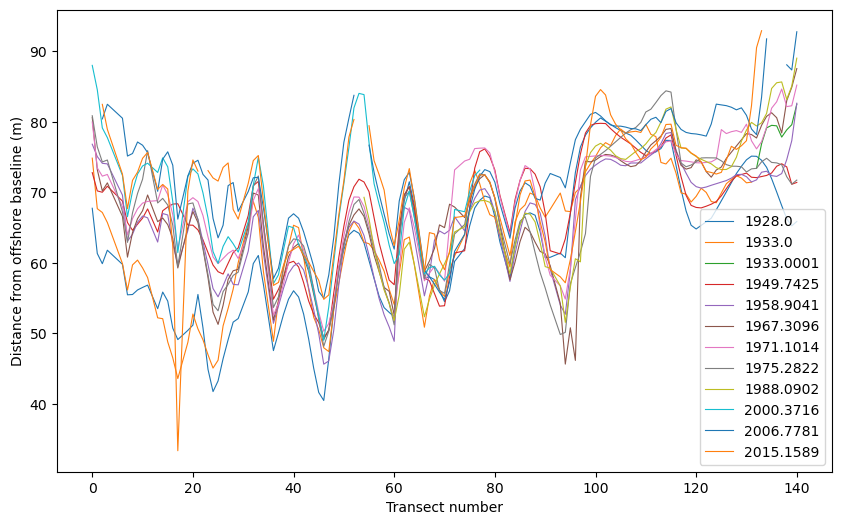

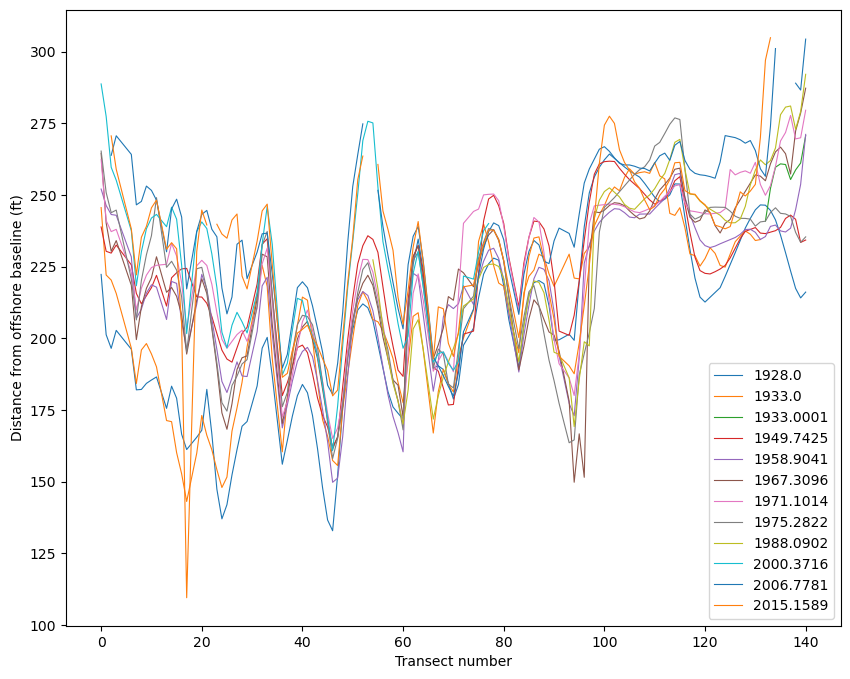

In [36]:

# Assuming data_orig, bounds, x_data, t_data, t_weighted_means, t_data_mat_demean, 
# y_data, m_err, m_err2_mat_zero, ST_ndat, ST_r, ST_r_var, ST_r_sm, ST_r_var_sm_corr,
# ST_int, ST_int_var, ST_y, ST_y_var, ST_y_sm, ST_y_var_sm, ST_alpha, alpha_zero, alpha_df,
# Cd_hat, ST_Cm, ST_Cm_sm, ST_res, ST_df, ST_df_less2, S, rvar_ac_damp are defined earlier

# Construct correlated rate var matrix.
r_corr_mat = toeplitz(rvar_ac_damp)
r_var_mat = np.sqrt(ST_r_var) * np.sqrt(ST_r_var.T)
r_corr_var_mat = r_corr_mat * r_var_mat
# del r_corr_mat, r_var_mat  # clear variables

# Create a model covariance matrix that includes the smoothed correlated rate errors.
ST_Cm_sm = ST_Cm.copy()
ST_Cm_sm[:I, :I] = S @ r_corr_var_mat @ S.T  # replace uncorrelated rate vars with correlated vars

# Calculate smoothed ST rates, rate variances, intercepts, intercept variances, and positions
# using boundaries in the boundary file.
ST_r_sm = S @ ST_r
ST_r_var_sm_corr = np.diag(S @ r_corr_var_mat @ S.T)
ST_y_sm = np.reshape(G_orig @ np.hstack([S @ ST_r, ST_int]), (I, J))  # only rates smoothed, not intercepts
ST_var_sm = (G_orig @ ST_Cm_sm @ G_orig.T).diagonal()  # only rate variance correlated and smoothed
ST_y_var_sm = np.reshape(ST_var_sm, (I, J))
# del ST_var_sm  # clear variable

# Put results into a structure called ST
ST = {
    'data_orig': data_orig,
    'bounds': bounds,
    'x_data': x_data,
    't_data': t_data.T,
    't_weighted_means': t_weighted_means,
    't_data_mat_demean': t_data_mat_demean,
    'y_data': y_data,
    'm_err': m_err,
    'm_err2_mat_zero': m_err2_mat_zero,
    'ndat': ST_ndat,  # number of data used to calculate each rate
    'rate': -ST_r,
    'rate_var': ST_r_var,
    'rate_sm': -ST_r_sm,
    'rate_var_sm': ST_r_var_sm_corr,
    'int': ST_int,
    'int_var': ST_int_var,
    'pos': ST_y,
    'pos_var': ST_y_var,
    'pos_sm': ST_y_sm,
    'pos_var_sm': ST_y_var_sm,
    'alpha': ST_alpha,
    'alpha_zero': alpha_zero,
    'alpha_df': alpha_df,
    'Cd': Cd_hat,
    'Cm': ST_Cm,
    'Cm_sm': ST_Cm_sm,
    'res': ST_res,
    'df': ST_df,
    'df_less2': ST_df_less2,
    'S': S,
    'rvar_ac_damp': rvar_ac_damp,
    'y_data_ft': y_data * m2ft,
    'm_err_ft': m_err * m2ft,
    'rate_ft': -ST_r * m2ft,
    'rate_var_ft': ST_r_var * (m2ft ** 2),
    'rate_sm_ft': -ST_r_sm * m2ft,
    'rate_var_sm_ft': ST_r_var_sm_corr * (m2ft ** 2),
    'int_ft': ST_int * m2ft,
    'int_var_ft': ST_int_var * (m2ft ** 2),
    'pos_ft': ST_y * m2ft,
    'pos_var_ft': ST_y_var * (m2ft ** 2),
    'pos_sm_ft': ST_y_sm * m2ft,
    'pos_var_sm_ft': ST_y_var_sm * (m2ft ** 2),
}


# Plot data in METERS
fig1, ax1 = plt.subplots(figsize=(10,6))
# ax1.grid(True)
for i in range(ST['y_data'].shape[1]):
    ax1.plot(ST['x_data'], ST['y_data'][:, i], label=str(ST['t_data'][i]), lw =0.8)
ax1.legend()
ax1.set_xlabel('Transect number')
ax1.set_ylabel('Distance from offshore baseline (m)')

# Plot data in FEET
fig101, ax101 = plt.subplots(figsize=(10,8))
# ax101.grid(True)
for i in range(ST['y_data_ft'].shape[1]):
    ax101.plot(ST['x_data'], ST['y_data_ft'][:, i], label=str(ST['t_data'][i]), lw=0.8)
ax101.legend()
ax101.set_xlabel('Transect number')
ax101.set_ylabel('Distance from offshore baseline (ft)')

# ----------------------------------------------------------------------
# Plot smoothed ST rates, non-smoothed ST rates, and unsmoothed intercepts

# --------------
# METERS
# --------------


In [ ]:
bounds

In [ ]:
for bind in bounds:
    print(binds)

In [ ]:
binds = [None] * nbounds

for nb in range(1, nbounds + 1):
    trb = bounds[nb * 2 - 2:nb * 2, 0]  # [start end] transect numbers for boundary
    bind1 = np.where(x_data == trb[0])[0][0]  # start index of boundary
    bind2 = np.where(x_data == trb[1])[0][0]  # end index of boundary
    binds[nb - 1] = list(range(bind1, bind2 + 1))

binds[2]

In [ ]:
x_data #[binds[nb]][[0, -1]]

In [ ]:
print(min_rate_conf.min(), max_rate_conf.max())

In [ ]:
# x_data[binds[nb]][[0, -1]]

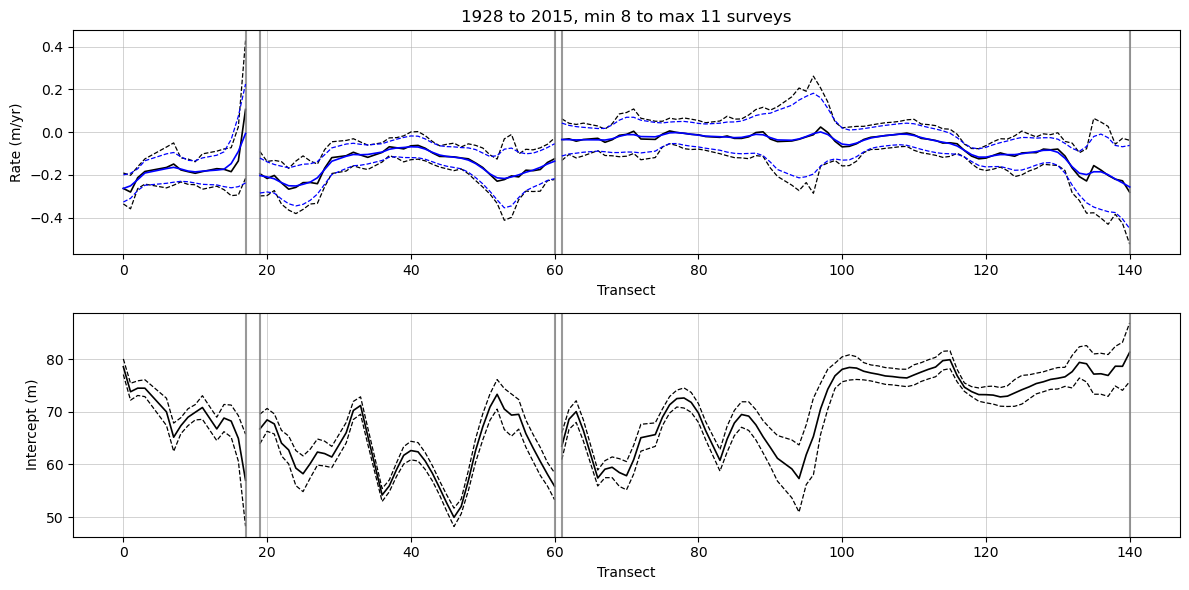

In [32]:
####################################################################
############################ METERS ################################
####################################################################

# Determine y-limits (rates and intercepts) for plotting boundaries
max_rate_conf = np.maximum(ST['rate'] + t.ppf(0.975, ST['df']) * np.sqrt(ST['rate_var']),
                            ST['rate'] - t.ppf(0.975, ST['df']) * np.sqrt(ST['rate_var']))
min_rate_conf = np.minimum(ST['rate'] + t.ppf(0.975, ST['df']) * np.sqrt(ST['rate_var']),
                            ST['rate'] - t.ppf(0.975, ST['df']) * np.sqrt(ST['rate_var']))
max_int_conf = np.maximum(ST['int'] + t.ppf(0.975, ST['df']) * np.sqrt(ST['int_var']),
                            ST['int'] - t.ppf(0.975, ST['df']) * np.sqrt(ST['int_var']))
min_int_conf = np.minimum(ST['int'] + t.ppf(0.975, ST['df']) * np.sqrt(ST['int_var']),
                            ST['int'] - t.ppf(0.975, ST['df']) * np.sqrt(ST['int_var']))

# Each cell holds an array of indices corresponding to the transects of
# that boundary segment
binds = [None] * nbounds

for nb in range(1, nbounds + 1):
    trb = bounds[nb * 2 - 2:nb * 2, 0]  # [start end] transect numbers for boundary
    bind1 = np.where(x_data == trb[0])[0][0]  # start index of boundary
    bind2 = np.where(x_data == trb[1])[0][0]  # end index of boundary
    binds[nb - 1] = list(range(bind1, bind2 + 1))


fig10, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].grid(True, lw=0.4)
axs[1].grid(True, lw=0.4)

for nb in range(nbounds):
    # Non-smoothed rates
    axs[0].plot(x_data[binds[nb]], ST['rate'][binds[nb]], 'k', lw=1.2)
    axs[0].plot(x_data[binds[nb]],
                ST['rate'][binds[nb]] + t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['rate_var'][binds[nb]]), 'k--', lw=0.9)
    axs[0].plot(x_data[binds[nb]],
                ST['rate'][binds[nb]] - t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['rate_var'][binds[nb]]), 'k--', lw=0.9)
    # axs[0].plot(x_data[binds[nb]][[0, -1]], [max_rate_conf[nb], min_rate_conf[nb]], color=[0.5, 0.5, 0.5])
    ## , ymin=min_rate_conf.min(), ymax=max_rate_conf.max()
    if nb == 0:
        axs[0].axvline(x_data[binds[nb][-1]], color='gray', alpha=0.8)
    elif nb != 0 and nb != (nbounds):
        axs[0].axvline(x_data[binds[nb][0]], color='gray', alpha=0.8)
        axs[0].axvline(x_data[binds[nb][-1]], color='gray', alpha=0.8)
    # Smoothed rates
    if crap_tr_inds.size==0:
        axs[0].plot(x_data[binds[nb]], ST['rate_sm'][binds[nb]], 'b', lw=1.2)
        axs[0].plot(x_data[binds[nb]],
                    ST['rate_sm'][binds[nb]] + t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['rate_var_sm'][binds[nb]]), 'b--', lw=0.9)
        axs[0].plot(x_data[binds[nb]],
                    ST['rate_sm'][binds[nb]] - t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['rate_var_sm'][binds[nb]]), 'b--', lw=0.9)

axs[0].set_xlabel('Transect')
axs[0].set_ylabel('Rate (m/yr)')
# axs[0].legend(['non-smoothed', '95% conf', '95% conf', 'boundary', 'smoothed (BLUE ONLY)'], loc='upper left')
axs[0].set_title(f"{t_data[0]} to {t_data[-1]}, min {np.nanmin(ST['df']+2)} to max {np.nanmax(ST['df']+2)} surveys")
axs[0].set_title(f"{int(t_data[0])} to {int(t_data[-1])}, min {np.nanmin(ST['df']+2)} to max {np.nanmax(ST['df']+2)} surveys")


# Unsmoothed intercepts
for nb in range(nbounds):
    axs[1].plot(x_data[binds[nb]], ST['int'][binds[nb]], 'k', lw=1.2)
    axs[1].plot(x_data[binds[nb]],
                ST['int'][binds[nb]] + t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['int_var'][binds[nb]]), 'k--', lw=0.9)
    axs[1].plot(x_data[binds[nb]],
                ST['int'][binds[nb]] - t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['int_var'][binds[nb]]), 'k--', lw=0.9)
    if nb == 0:
        axs[1].axvline(x_data[binds[nb][-1]], color='gray', alpha=0.8)
    elif nb != 0 and nb != (nbounds):
        axs[1].axvline(x_data[binds[nb][0]], color='gray', alpha=0.8)
        axs[1].axvline(x_data[binds[nb][-1]], color='gray', alpha=0.8)
    # axs[1].plot(x_data[binds[nb]][[0, -1]], [max_int_conf[nb], min_int_conf[nb]], color=[0.5, 0.5, 0.5])

axs[1].set_xlabel('Transect')
axs[1].set_ylabel('Intercept (m)')
# axs[1].legend(['non-smoothed', '95% conf', '95% conf', 'boundary'], loc='upper left')

plt.tight_layout()
plt.show()



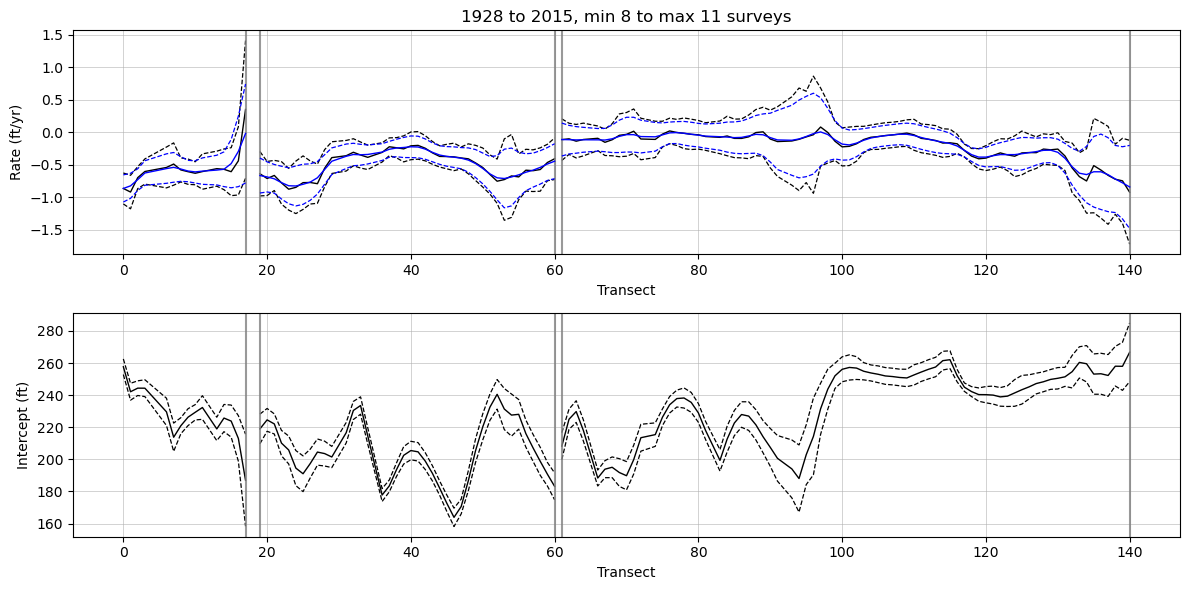

In [35]:
####################################################################
############################ feet ################################
####################################################################

# Determine y-limits (rates and intercepts) for plotting boundaries
max_rate_conf = np.maximum(ST['rate_ft'] + t.ppf(0.975, ST['df']) * np.sqrt(ST['rate_var']),
                            ST['rate_ft'] - t.ppf(0.975, ST['df']) * np.sqrt(ST['rate_var']))
min_rate_conf = np.minimum(ST['rate_ft'] + t.ppf(0.975, ST['df']) * np.sqrt(ST['rate_var']),
                            ST['rate_ft'] - t.ppf(0.975, ST['df']) * np.sqrt(ST['rate_var']))
max_int_conf = np.maximum(ST['int'] + t.ppf(0.975, ST['df']) * np.sqrt(ST['int_var']),
                            ST['int'] - t.ppf(0.975, ST['df']) * np.sqrt(ST['int_var']))
min_int_conf = np.minimum(ST['int'] + t.ppf(0.975, ST['df']) * np.sqrt(ST['int_var']),
                            ST['int'] - t.ppf(0.975, ST['df']) * np.sqrt(ST['int_var']))

# Each cell holds an array of indices corresponding to the transects of
# that boundary segment
binds = [None] * nbounds

for nb in range(1, nbounds + 1):
    trb = bounds[nb * 2 - 2:nb * 2, 0]  # [start end] transect numbers for boundary
    bind1 = np.where(x_data == trb[0])[0][0]  # start index of boundary
    bind2 = np.where(x_data == trb[1])[0][0]  # end index of boundary
    binds[nb - 1] = list(range(bind1, bind2 + 1))


fig10, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].grid(True, lw=0.4)
axs[1].grid(True, lw=0.4)

for nb in range(nbounds):
    # Non-smoothed rates
    axs[0].plot(x_data[binds[nb]], ST['rate_ft'][binds[nb]], 'k', lw=1)
    axs[0].plot(x_data[binds[nb]],
                ST['rate_ft'][binds[nb]] + t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['rate_var_ft'][binds[nb]]), 'k--', lw=0.9)
    axs[0].plot(x_data[binds[nb]],
                ST['rate_ft'][binds[nb]] - t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['rate_var_ft'][binds[nb]]), 'k--', lw=0.9)
    # axs[0].plot(x_data[binds[nb]][[0, -1]], [max_rate_conf[nb], min_rate_conf[nb]], color=[0.5, 0.5, 0.5])
    ## , ymin=min_rate_conf.min(), ymax=max_rate_conf.max()
    if nb == 0:
        axs[0].axvline(x_data[binds[nb][-1]], color='gray', alpha=0.8)
    elif nb != 0 and nb != (nbounds):
        axs[0].axvline(x_data[binds[nb][0]], color='gray', alpha=0.8)
        axs[0].axvline(x_data[binds[nb][-1]], color='gray', alpha=0.8)
    # Smoothed rates
    if crap_tr_inds.size==0:
        axs[0].plot(x_data[binds[nb]], ST['rate_sm_ft'][binds[nb]], 'b', lw=1)
        axs[0].plot(x_data[binds[nb]],
                    ST['rate_sm_ft'][binds[nb]] + t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['rate_var_sm_ft'][binds[nb]]), 'b--', lw=0.9)
        axs[0].plot(x_data[binds[nb]],
                    ST['rate_sm_ft'][binds[nb]] - t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['rate_var_sm_ft'][binds[nb]]), 'b--', lw=0.9)

axs[0].set_xlabel('Transect')
axs[0].set_ylabel('Rate (ft/yr)')
# axs[0].legend(['non-smoothed', '95% conf', '95% conf', 'boundary', 'smoothed (BLUE ONLY)'], loc='upper left')
axs[0].set_title(f"{t_data[0]} to {t_data[-1]}, min {np.nanmin(ST['df']+2)} to max {np.nanmax(ST['df']+2)} surveys")
axs[0].set_title(f"{int(t_data[0])} to {int(t_data[-1])}, min {np.nanmin(ST['df']+2)} to max {np.nanmax(ST['df']+2)} surveys")


# Unsmoothed intercepts
for nb in range(nbounds):
    axs[1].plot(x_data[binds[nb]], ST['int_ft'][binds[nb]], 'k', lw=1)
    axs[1].plot(x_data[binds[nb]],
                ST['int_ft'][binds[nb]] + t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['int_var_ft'][binds[nb]]), 'k--', lw=0.9)
    axs[1].plot(x_data[binds[nb]],
                ST['int_ft'][binds[nb]] - t.ppf(0.975, ST['df'][binds[nb]]) * np.sqrt(ST['int_var_ft'][binds[nb]]), 'k--', lw=0.9)
    if nb == 0:
        axs[1].axvline(x_data[binds[nb][-1]], color='gray', alpha=0.8)
    elif nb != 0 and nb != (nbounds):
        axs[1].axvline(x_data[binds[nb][0]], color='gray', alpha=0.8)
        axs[1].axvline(x_data[binds[nb][-1]], color='gray', alpha=0.8)
    # axs[1].plot(x_data[binds[nb]][[0, -1]], [max_int_conf[nb], min_int_conf[nb]], color=[0.5, 0.5, 0.5])

axs[1].set_xlabel('Transect')
axs[1].set_ylabel('Intercept (ft)')
# axs[1].legend(['non-smoothed', '95% conf', '95% conf', 'boundary'], loc='upper left')

plt.tight_layout()
plt.show()


In [45]:
pd.DataFrame.from_dict(ST, orient='index')

c:\Users\abm20\Anaconda3\envs\coastsat_ps\lib\site-packages\pandas\core\internals\construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


,0
data_orig,"[[nan, 1928.0, 1933.0, 1933.0001, 1949.7425, 1..."
bounds,"[[0.0, 0.0], [17.0, 0.0], [19.0, 0.0], [60.0, ..."
x_data,"[0.0, 1.0, 2.0, 3.0, 6.0, 7.0, 8.0, 9.0, 10.0,..."
t_data,"[1928.0, 1933.0, 1933.0001, 1949.7425, 1958.90..."
t_weighted_means,"[1964.9015467975796, 1964.9015467975796, 1977...."
t_data_mat_demean,"[[-36.90154679757961, -31.901546797579613, -31..."
y_data,"[[67.7519, 74.8569, nan, 72.8003, 76.8291, 80...."
m_err,"[[5.8148, 7.2391, 7.2918, 4.0975, 5.4854, 4.28..."
m_err2_mat_zero,"[[0.029575387020320407, 0.019082305659753412, ..."
ndat,"[8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,..."


,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,-0.263372,-0.280193,-0.212782,-0.183985,-0.165127,-0.149085,-0.176621,-0.18483,-0.192265,-0.18432,...,-0.111335,-0.167625,-0.208043,-0.228343,-0.156314,-0.177254,-0.202034,-0.220248,-0.227659,-0.281204


In [59]:
# {k: ST.get(k,None) for k in {'rate', 'rate_var', 'rate_sm', 'int', 'int_var'}}
w = ['rate', 'rate_var', 'rate_sm', 'rate_var_sm', 'int', 'int_var']

ST_subset = dict((k, ST[k]) for k in w if k in ST)

In [61]:
ST_subset.keys()

dict_keys(['rate', 'rate_var', 'rate_sm', 'int', 'int_var'])

In [64]:
pd.DataFrame.from_dict(ST_subset, orient='index')

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
rate,-0.263372,-0.280193,-0.212782,-0.183985,-0.165127,-0.149085,-0.176621,-0.184830,-0.192265,-0.184320,...,-0.111335,-0.167625,-0.208043,-0.228343,-0.156314,-0.177254,-0.202034,-0.220248,-0.227659,-0.281204
rate_var,0.000876,0.001027,0.000494,0.000655,0.001720,0.001843,0.000593,0.000657,0.000545,0.001288,...,0.000873,0.002552,0.002353,0.004061,0.008150,0.008431,0.008770,0.004821,0.007084,0.010573
rate_sm,-0.263358,-0.251118,-0.221919,-0.190995,-0.170327,-0.164576,-0.172480,-0.181863,-0.185858,-0.182253,...,-0.122090,-0.161821,-0.191982,-0.198436,-0.185264,-0.185377,-0.198973,-0.219137,-0.237057,-0.256583
int,0.935962,0.237084,0.556309,0.658614,0.575176,0.307605,0.763985,0.449511,0.726031,0.049328,...,0.761130,0.776214,0.905172,0.115874,0.477833,0.519500,0.494486,0.034005,0.700969,0.183424
int_var,0.542352,0.176696,0.208030,0.404783,0.827951,0.816190,0.338147,0.845689,0.308513,0.032821,...,0.404383,0.687435,0.727383,0.457482,0.312287,0.787395,0.855209,0.093574,0.271975,0.425595


In [ ]:

# # Determine y-limits (rates and intercepts) for plotting boundaries
# max_rate_conf = np.maximum(ST.rate + t.ppf(0.975, ST.df) * np.sqrt(ST.rate_var),
#                             ST.rate - t.ppf(0.975, ST.df) * np.sqrt(ST.rate_var))
# min_rate_conf = np.minimum(ST.rate + t.ppf(0.975, ST.df) * np.sqrt(ST.rate_var),
#                             ST.rate - t.ppf(0.975, ST.df) * np.sqrt(ST.rate_var))
# max_int_conf = np.maximum(ST.int + t.ppf(0.975, ST.df) * np.sqrt(ST.int_var),
#                             ST.int - t.ppf(0.975, ST.df) * np.sqrt(ST.int_var))
# min_int_conf = np.minimum(ST.int + t.ppf(0.975, ST.df) * np.sqrt(ST.int_var),
#                             ST.int - t.ppf(0.975, ST.df) * np.sqrt(ST.int_var))

# # Each cell holds an array of indices corresponding to the transects of
# # that boundary segment
# binds = [np.arange(bind[0], bind[1] + 1) for bind in bounds]
                        
# fig10, axs = plt.subplots(2, 1, figsize=(10, 8))
# axs[0].grid(True)
# axs[1].grid(True)

# for nb in range(nbounds):
#     # Non-smoothed rates
#     axs[0].plot(x_data[binds[nb]], ST.rate[binds[nb]], 'k')
#     axs[0].plot(x_data[binds[nb]],
#                 ST.rate[binds[nb]] + t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var[binds[nb]]), 'k--')
#     axs[0].plot(x_data[binds[nb]],
#                 ST.rate[binds[nb]] - t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var[binds[nb]]), 'k--')
#     axs[0].plot(x_data[binds[nb]][[0, -1]], [max_rate_conf[nb], min_rate_conf[nb]], color=[0.5, 0.5, 0.5])

#     # Smoothed rates
#     if not crap_tr_inds:
#         axs[0].plot(x_data[binds[nb]], ST.rate_sm[binds[nb]], 'b')
#         axs[0].plot(x_data[binds[nb]],
#                     ST.rate_sm[binds[nb]] + t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var_sm[binds[nb]]), 'b--')
#         axs[0].plot(x_data[binds[nb]],
#                     ST.rate_sm[binds[nb]] - t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var_sm[binds[nb]]), 'b--')

# axs[0].set_xlabel('Transect')
# axs[0].set_ylabel('Rate (m/yr)')
# axs[0].legend(['non-smoothed', '95% conf', '95% conf', 'boundary', 'smoothed (BLUE ONLY)'], loc='upper left')
# axs[0].set_title(f"{t_data[0]} to {t_data[-1]}, min {np.nanmin(ST_df+2)} to max {np.nanmax(ST_df+2)} surveys")

# # Unsmoothed intercepts
# for nb in range(nbounds):
#     axs[1].plot(x_data[binds[nb]], ST.int[binds[nb]], 'k')
#     axs[1].plot(x_data[binds[nb]],
#                 ST.int[binds[nb]] + t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var[binds[nb]]), 'k--')
#     axs[1].plot(x_data[binds[nb]],
#                 ST.int[binds[nb]] - t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var[binds[nb]]), 'k--')
#     axs[1].plot(x_data[binds[nb]][[0, -1]], [max_int_conf[nb], min_int_conf[nb]], color=[0.5, 0.5, 0.5])

# axs[1].set_xlabel('Transect')
# axs[1].set_ylabel('Intercept (m)')
# axs[1].legend(['non-smoothed', '95% conf', '95% conf', 'boundary'], loc='upper left')

# plt.tight_layout()
# plt.show()


# # Plot smoothed ST rates, non-smoothed ST rates, and unsmoothed intercepts in METERS
# fig10, (ax10_rate, ax10_int) = plt.subplots(2, 1, sharex=True)
# ax10_rate.grid(True)
# ax10_int.grid(True)
# for nb in range(nbounds):
#     ax10_rate.plot(ST.x_data[binds[nb]], ST.rate[binds[nb]], 'k')  # non-smoothed rates
#     ax10_rate.plot(ST.x_data[binds[nb]], ST.rate[binds[nb]] +
#                     t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var[binds[nb]]), 'k--')  # 95% two tail
#     ax10_rate.plot(ST.x_data[binds[nb]], ST.rate[binds[nb]] -
#                     t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var[binds[nb]]), 'k--')  # 95% two tail
#     ax10_int.plot(ST.x_data[binds[nb]], ST.int[binds[nb]], 'k')  # non-smoothed intercepts
#     ax10_int.plot(ST.x_data[binds[nb]], ST.int[binds[nb]] +
#                     t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var[binds[nb]]), 'k--')  # 95% two tail
#     ax10_int.plot(ST.x_data[binds[nb]], ST.int[binds[nb]] -
#                     t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var[binds[nb]]), 'k--')  # 95% two tail
# ax10_rate.set_ylabel('Rate (m/yr)')
# ax10_int.set_xlabel('Transect')
# ax10_int.set_ylabel('Intercept (m)')

# # Plot smoothed ST rates, non-smoothed ST rates, and unsmoothed intercepts in FEET
# fig1001, (ax1001_rate, ax1001_int) = plt.subplots(2, 1, sharex=True)
# ax1001_rate.grid(True)
# ax1001_int.grid(True)
# for nb in range(nbounds):
#     ax1001_rate.plot(ST.x_data[binds[nb]], ST.rate_ft[binds[nb]], 'k')  # non-smoothed rates
#     ax1001_rate.plot(ST.x_data[binds[nb]], ST.rate_ft[binds[nb]] +
#                         t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var_ft[binds[nb]]), 'k--')  # 95% two tail
#     ax1001_rate.plot(ST.x_data[binds[nb]], ST.rate_ft[binds[nb]] -
#                         t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var_ft[binds[nb]]), 'k--')  # 95% two tail
#     ax1001_int.plot(ST.x_data[binds[nb]], ST.int_ft[binds[nb]], 'k')  # non-smoothed intercepts
#     ax1001_int.plot(ST.x_data[binds[nb]], ST.int_ft[binds[nb]] +
#                     t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var_ft[binds[nb]]), 'k--')  # 95% two tail
#     ax1001_int.plot(ST.x_data[binds[nb]], ST.int_ft[binds[nb]] -
#                     t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var_ft[binds[nb]]), 'k--')  # 95% two tail
# ax1001_rate.set_ylabel('Rate (ft/yr)')
# ax1001_int.set_xlabel('Transect')
# ax1001_int.set_ylabel('Intercept (ft)')

# # Store figures in a dictionary
# figs_out = {'data_METERS': fig1, 'params_METERS': fig10, 'data_FEET': fig101, 'params_FEET': fig1001}

# plt.show()

# # return ST, figs_out

In [ ]:
########## THINGS TO CHECK IF WRONG: 
# NANs are only removed for r and not int in G_mod

In [ ]:

def AAA_ST_regress(data_orig, bounds, flag_df_one_add_one):
    m2ft = 3.28084  # conversion factor for meters to feet

    # Determine transects with < three data points
    crap_tr_inds = np.where(np.sum(~np.isnan(data_orig[2:, 1:]), axis=1) < 3)[0]
    good_tr_inds = np.arange(data_orig.shape[0] - 2)
    good_tr_inds = np.delete(good_tr_inds, crap_tr_inds)

    if len(crap_tr_inds) == 0:
        data_orig_cond = data_orig
    else:
        data_orig_cond = np.delete(data_orig, crap_tr_inds + 2, axis=0)
    
    # Define distances between transects
    dx_tr = 20; #meters
    
    
    # Define some variables from data input
   
    x_data = data_orig_cond[2: , 0] #transect numbers (starts with 0 in python?)
    x_dist = np.array(x_data-x_data[1]+2)*dx_tr  #convert transect numbers to distances;first transect is 20m, 2nd is 40m, etc
    y_data = data_orig_cond[2:,1:] #shoreline positions (m) (distance from baseline)
    t_data = data_orig_cond[0,1:] #survey times (year)
    I = len(x_data) #number of transects (spatial)
    J = len(t_data) #number of surveys (time)
    m_err = np.tile(data_orig_cond[1, 1:], (I, 1)) #put measurement errors in matrix m_err. represents main diagonal. repeated values of the errors. 

    
    # Create initial data covariance matrix
    # (diagonal sparse matrix of squared measurement errors)
    Cd_orig = sp.diags(np.reshape(m_err ** 2, J * I), offsets=0) #shape should be square
    Cd_orig_csc = Cd_orig.tocsc()            # formatting
    Cd_inv_orig = sp.linalg.inv(Cd_orig_csc) # invert the square matrix
    Cd_orig_half_sparse = np.sqrt(Cd_orig_csc.data)


    # Calculate rates and parameters using ST method

    # Determine weighted mean of times for each transect
    m_err2_mat_zero = 1 / (m_err ** 2)  # calculate each err^(-2)
    m_err2_mat_zero[np.isnan(y_data)] = 0  # set to zero where there is no data
    t_weighted_means = np.sum(m_err2_mat_zero * t_data.reshape(1, -1)) / np.sum(m_err2_mat_zero, axis=1)
    
    # define time and data arrays (with and without NaN data values)
    t_data_mat = np.tile(t_data, (I, 1))
    t_data_mat_demean = t_data_mat - np.tile(t_weighted_means[:, np.newaxis], (1, J))
    
    d_orig = y_data.reshape(J * I, 1)
    nan_inds = np.isnan(d_orig)
    d_mod = d_orig[~nan_inds]
    N = len(d_mod)  # number of total data points


    # Assuming G_orig, nan_inds, Cd_orig are defined earlier

    # Define system matrix (includes NaN data)
    i = np.arange(1, len(d_orig)+1)
    j = np.tile(np.arange(1, I+1), J)
    sp_ = np.reshape(t_data_mat_demean, (J * I, 1)) # very long vector
    G_r = sp.coo_matrix((sp_.flatten, (i, j)), shape=(len(d_orig), I))  # system matrix (portion) for rate only
    G_i = sp.csr_matrix((np.ones_like(sp_), (i, j)), shape=(len(d_orig), I))  # system matrix (portion) for intercept only
    G_orig = sp.hstack([G_r, G_i])  # complete system matrix for rate and intercept
    
    # Remove rows in the system matrix and covariance matrix where data is nan
    G_mod = G_orig.copy()  # set G_mod (G model) by removing rows/cols for missing data
    G_mod = G_mod[~nan_inds, :]
    Cd0_mod = Cd_orig.copy()
    Cd0_mod = Cd0_mod[~nan_inds, :]
    Cd0_mod = Cd0_mod[:, ~nan_inds]
    Cd0_mod_inv = np.linalg.inv(Cd0_mod)


    # Assuming G_mod, Cd0_mod, d_mod, m_err are defined earlier
    
    # Invert for ST rates and intercepts
    m_ST = np.linalg.lstsq(G_mod.T @ np.linalg.inv(Cd0_mod) @ G_mod, G_mod.T @ np.linalg.inv(Cd0_mod) @ d_mod, rcond=None)[0]
    ST_r = m_ST[:I]
    ST_int = m_ST[I:]
    ST_y = np.reshape(G_orig @ m_ST, (I, J))  # make predictions for dates where no data exist (NaNs)
    ST_res = y_data - ST_y  # when subtracting NaNs, will be NaN.
    
    # Compute covariance scaling factor (alpha)
    STi = np.reshape(np.tile(np.arange(1, I + 1), J), (I * J, 1))
    STj = np.arange(1, I * J + 1)
    STs = np.reshape(ST_res.T, (I * J, 1))
    ST_tr = sp.csr_matrix((STs, (STi, STj)), shape=(I * J, I))
    CSTtr = sp.diags(np.reshape(m_err ** 2, I * J), 0, I * J, I * J)
    remove_nan = np.isnan(np.reshape(ST_res.T, I * J))
    ST_tr = ST_tr[:, ~remove_nan]
    CSTtr = CSTtr[~remove_nan, :]
    CSTtr = CSTtr[:, ~remove_nan]
    alpha_df = np.sum(~np.isnan(ST_res), axis=1) - 2  # degrees of freedom used to calculate alpha
    
    if flag_df_one_add_one:  # if alpha == 1 (three shorelines), add one degree of freedom
        alpha_one = (alpha_df == 1)
        alpha_df[alpha_one] = 2
        if np.sum(alpha_one) > 0:
            print(f"Adding degree of freedom to Transects: {x_data[alpha_one]}")
    
    ST_alpha = np.diag(ST_tr @ np.linalg.inv(CSTtr) @ ST_tr.T) / alpha_df
    alpha_zero = np.where(alpha_df < 1)[0]  # find df == 0 (only 2 shorelines)
    # ST_alpha[alpha_zero] = ST_alpha[alpha_zero - 1]  # Set this alpha to the one next to it.
    # ST_alpha[alpha_zero] = np.nan  # set the alpha with zero df to nan because it will be infinity (can't divide by zero)
    # ST_alpha[alpha_zero] = np.nanmean(ST_alpha)  # use the mean of alphas in this section as the alpha value for statistical calculations

    # Assuming Cd_orig, ST_alpha, G_mod are defined earlier
    
    # Define new scaled data covariance matrix
    Cd_hat = sp.diags(np.tile(ST_alpha, J), 0, J * I, J * I) @ Cd_orig
    Cd_hat[nan_inds, :] = []
    Cd_hat[:, nan_inds] = []
    Cd_hat_inv = np.linalg.inv(Cd_hat)
    
    # ST model covariance matrix
    ST_Cm = np.linalg.inv(G_mod.T @ Cd_hat_inv @ G_mod)
    
    # ST rate and intercept variances
    ST_r_var = np.diag(ST_Cm[:I, :I])
    ST_int_var = np.diag(ST_Cm[I:, I:])
    
    # ST position prediction variance
    ST_var = np.diag(G_orig @ ST_Cm @ G_orig.T)
    ST_y_var = np.reshape(ST_var, (I, J))
    
    # Number of data (shoreline positions) per transect used in regression
    ST_ndat = np.sum(~np.isnan(y_data), axis=1)
    
    # Student's t-distribution
    ST_df = alpha_df  # use the same degrees of freedom for the T-distribution later, and for that used in determining the uncertainty
    ST_df_less2 = x_data[ST_df < 2]
    # ST_df[ST_df < 2] = 2  # set minimum df to 2 because tinv can blow up for
    # # transects where there are only a few shorelines
    # # due to seawall truncation.
    # # This should never happen because data was checked to ensure only transects with four or more data are used.
    # ST_tconf95two = stats.t.ppf(percent95two, ST_df)
    # ST_tconf90two95one = stats.t.ppf(percent90two95one, ST_df)
    # ST_tconf80two90one = stats.t.ppf(percent80two90one, ST_df)
    # ST_tconf80one = stats.t.ppf(percent80one, ST_df)

    
    # Assuming x_data, y_data, t_data, m_err, bounds, ST_r, ST_r_var, ST_int, ST_int_var, ST_y, ST_y_var, ST_alpha, ST_res, alpha_df, alpha_zero, ST_df, ST_df_less2 are defined earlier
    
    # Set the rates, etc. to NaN for the transects with <3 data points,
    # and also set the rates, etc. to NaN for "smoothed" data results.
    # Note: No smoothing when transects are removed.
    if len(crap_tr_inds) > 0:
        print(f"Rates will not be smoothed. {len(crap_tr_inds)} out of {I + len(crap_tr_inds)} transects have less than 3 data points.")
        
        # set non-smooth rates, etc. to NaN for transects with sparse data,
        # and insert those values into the rate, etc. arrays.
        x_data = data_orig[2:, 0]  # transect numbers
        y_data = data_orig[2:, 1:]  # shoreline positions (m) (distance from baseline)
        t_data = data_orig[0, 1:]  # survey times (year)
        m_err = np.tile(data_orig[1, 1:], (I, 1))  # put measurement errors in matrix m_err
        I, J = y_data.shape
        nbounds = len(bounds) // 2
        
        ST_r_alt = np.full(I, np.nan)
        ST_r_alt[good_tr_inds] = ST_r
        ST_r_var_alt = np.full(I, np.nan)
        ST_r_var_alt[good_tr_inds] = ST_r_var
        ST_int_alt = np.full(I, np.nan)
        ST_int_alt[good_tr_inds] = ST_int
        ST_int_var_alt = np.full(I, np.nan)
        ST_int_var_alt[good_tr_inds] = ST_int_var
        
        ST_y_alt = np.full((I, J), np.nan)
        ST_y_var_alt = np.full((I, J), np.nan)
        for ind in range(len(good_tr_inds)):
            ST_y_alt[good_tr_inds[ind], :] = ST_y[ind, :]
            ST_y_var_alt[good_tr_inds[ind], :] = ST_y_var[ind, :]
        
        ST_alpha_alt = np.full(I, np.nan)
        ST_alpha_alt[good_tr_inds] = ST_alpha
        ST_res_alt = y_data - ST_y_alt  # when subtracting NaNs, will be NaN.
        alpha_df_alt = np.sum(~np.isnan(ST_res_alt), axis=1) - 2
        alpha_df_alt[crap_tr_inds] = np.nan
        alpha_zero_alt = crap_tr_inds  # find df <= 0 (< 3 shorelines)
        ST_df_alt = alpha_df_alt
        ST_df_less2_alt = np.sort(np.concatenate([x_data[ST_df_alt < 2], x_data[crap_tr_inds]]))
        
        # rename variables for insertion into ST structure
        ST_r = ST_r_alt
        ST_r_var = ST_r_var_alt
        ST_int = ST_int_alt
        ST_int_var = ST_int_var_alt
        ST_y = ST_y_alt
        ST_y_var = ST_y_var_alt
        ST_alpha = ST_alpha_alt
        ST_res = ST_res_alt
        alpha_df = alpha_df_alt
        alpha_zero = alpha_zero_alt
        ST_df = ST_df_alt
        ST_df_less2 = ST_df_less2_alt
        
        # clear variables
        del ST_r_alt, ST_r_var_alt, ST_int_alt, ST_int_var_alt, ST_y_alt, ST_y_var_alt, ST_alpha_alt, ST_res_alt, alpha_df_alt, alpha_zero_alt, ST_df_alt, ST_df_less2_alt
        
        # set "smooth" variables to NaN
        ST_r_sm = np.nan
        ST_r_var_sm_corr = np.nan
        ST_y_sm = np.nan
        ST_y_var_sm = np.nan
        ST_Cm_sm = np.nan
        S = np.nan
        rvar_ac_damp = np.nan
    
    else:  # only smooth if there were no transects removed
    
        # Create smoothing matrix according to boundaries defined in the file
        nbounds = len(bounds) // 2
        Snb = []
        mat_str = ""
        for nb in range(nbounds):
            trb = bounds[nb * 2 - 1:nb * 2 + 1, 0]
            numtr = np.where(x_data == trb[1])[0][0] - np.where(x_data == trb[0])[0][0] + 1
            Snb.append(make_smooth_mat(numtr))
            if not mat_str:
                msg = f"Snb[{nb}]"
            else:
                msg = f",Snb[{nb}]"
            mat_str = f"{mat_str}{msg}"
    
        S = block_diag(*Snb)
        # clear variables
        del Snb, mat_str, nb, trb, numtr

    # Assuming x_data, bounds, ST_r_var are defined earlier
    
    # Calculate autocorrelation of rate errors for use in calculating variance of
    # smoothed rates (to include alongshore correlation of rates so as not
    # to unfairly reduce variance in a smoothed rate). A smoothed rate is a
    # weighted average.
    
    # define number of transects in the largest boundary area
    bounds_inds = np.zeros(len(bounds))
    
    for k in range(len(bounds)):
        bounds_inds[k] = np.where(x_data == bounds[k])[0][0]
    
    bmax_trn = int(max(bounds_inds[1::2] - bounds_inds[0::2] + 1))
    
    # separate rate variances into boundary areas. Put in a matrix where each col is
    # a boundary area.
    rvar_bounds = np.full((bmax_trn, len(bounds) // 2), np.nan)
    
    for nb in range(len(bounds) // 2):
        trb = bounds[nb * 2 - 1:nb * 2 + 1, 0]  # [start end] transect numbers for boundary
        bind1 = np.where(x_data == trb[0])[0][0]  # start index of boundary
        bind2 = np.where(x_data == trb[1])[0][0]  # end index of boundary
        numtr = bind2 - bind1 + 1  # number of transects in this boundary
        rvar_bounds[:numtr, nb] = ST_r_var[bind1:bind2]
    
    # calculate mean rate variance of each boundary area
    rates_bounds_mean = np.nanmean(rvar_bounds, axis=0)
    
    # remove mean of each boundary section
    rates_bounds_nm = rvar_bounds - np.tile(rates_bounds_mean, (bmax_trn, 1))
    
    # replace nans with zeros
    rates_bounds_nm[np.isnan(rvar_bounds)] = 0
    
    # initialize a vector to hold autocorrelation to zeros so the large lags with no data will be zero
    rvar_ac = np.zeros(bmax_trn)
    
    # calculate autocovariance of all shoreline residuals
    for k in range(bmax_trn):
        resshift = np.vstack([rates_bounds_nm[k:, :], np.zeros((k - 1, len(bounds) // 2))])
        rvar_ac[k] = np.trace(np.dot(rates_bounds_nm.T, resshift)) / np.sum(resshift != 0) * (bmax_trn - (k - 1)) / bmax_trn
    
    # re-weight res_ac so its zero lag is 1
    rvar_ac /= rvar_ac[0]
    
    # damp autocovariance with cosine function so that the autocorrelation function
    # goes to zero at about 3/4 of the total number of lags (governed by l)
    l = 6
    damp = np.cos(np.pi * np.arange(I) / (2 * (I - 1))) ** l
    rvar_ac_damp = rvar_ac * damp
    
    
    # Assuming data_orig, bounds, x_data, t_data, t_weighted_means, t_data_mat_demean, 
    # y_data, m_err, m_err2_mat_zero, ST_ndat, ST_r, ST_r_var, ST_r_sm, ST_r_var_sm_corr,
    # ST_int, ST_int_var, ST_y, ST_y_var, ST_y_sm, ST_y_var_sm, ST_alpha, alpha_zero, alpha_df,
    # Cd_hat, ST_Cm, ST_Cm_sm, ST_res, ST_df, ST_df_less2, S, rvar_ac_damp are defined earlier
    
    # Construct correlated rate var matrix.
    r_corr_mat = toeplitz(rvar_ac_damp)
    r_var_mat = np.sqrt(ST_r_var) * np.sqrt(ST_r_var.T)
    r_corr_var_mat = r_corr_mat * r_var_mat
    del r_corr_mat, r_var_mat  # clear variables
    
    # Create a model covariance matrix that includes the smoothed correlated rate errors.
    ST_Cm_sm = ST_Cm.copy()
    ST_Cm_sm[:I, :I] = S @ r_corr_var_mat @ S.T  # replace uncorrelated rate vars with correlated vars
    
    # Calculate smoothed ST rates, rate variances, intercepts, intercept variances, and positions
    # using boundaries in the boundary file.
    ST_r_sm = S @ ST_r
    ST_r_var_sm_corr = np.diag(S @ r_corr_var_mat @ S.T)
    ST_y_sm = np.reshape(G_orig @ np.vstack([S @ ST_r, ST_int]), (I, J))  # only rates smoothed, not intercepts
    ST_var_sm = np.diag(G_orig @ ST_Cm_sm @ G_orig.T)  # only rate variance correlated and smoothed
    ST_y_var_sm = np.reshape(ST_var_sm, (I, J))
    del ST_var_sm  # clear variable
    
    # Put results into a structure called ST
    ST = {
        'data_orig': data_orig,
        'bounds': bounds,
        'x_data': x_data,
        't_data': t_data.T,
        't_weighted_means': t_weighted_means,
        't_data_mat_demean': t_data_mat_demean,
        'y_data': y_data,
        'm_err': m_err,
        'm_err2_mat_zero': m_err2_mat_zero,
        'ndat': ST_ndat,  # number of data used to calculate each rate
        'rate': -ST_r,
        'rate_var': ST_r_var,
        'rate_sm': -ST_r_sm,
        'rate_var_sm': ST_r_var_sm_corr,
        'int': ST_int,
        'int_var': ST_int_var,
        'pos': ST_y,
        'pos_var': ST_y_var,
        'pos_sm': ST_y_sm,
        'pos_var_sm': ST_y_var_sm,
        'alpha': ST_alpha,
        'alpha_zero': alpha_zero,
        'alpha_df': alpha_df,
        'Cd': Cd_hat,
        'Cm': ST_Cm,
        'Cm_sm': ST_Cm_sm,
        'res': ST_res,
        'df': ST_df,
        'df_less2': ST_df_less2,
        'S': S,
        'rvar_ac_damp': rvar_ac_damp,
        'y_data_ft': y_data * m2ft,
        'm_err_ft': m_err * m2ft,
        'rate_ft': -ST_r * m2ft,
        'rate_var_ft': ST_r_var * (m2ft ** 2),
        'rate_sm_ft': -ST_r_sm * m2ft,
        'rate_var_sm_ft': ST_r_var_sm_corr * (m2ft ** 2),
        'int_ft': ST_int * m2ft,
        'int_var_ft': ST_int_var * (m2ft ** 2),
        'pos_ft': ST_y * m2ft,
        'pos_var_ft': ST_y_var * (m2ft ** 2),
        'pos_sm_ft': ST_y_sm * m2ft,
        'pos_var_sm_ft': ST_y_var_sm * (m2ft ** 2),
    }
    
    
    # Plot data in METERS
    fig1, ax1 = plt.subplots()
    ax1.grid(True)
    for i in range(ST.y_data.shape[1]):
        ax1.plot(ST.x_data, ST.y_data[:, i], label=str(ST.t_data[i]))
    ax1.legend()
    ax1.set_xlabel('Transect number')
    ax1.set_ylabel('Distance from offshore baseline (m)')
    
    # Plot data in FEET
    fig101, ax101 = plt.subplots()
    ax101.grid(True)
    for i in range(ST.y_data_ft.shape[1]):
        ax101.plot(ST.x_data, ST.y_data_ft[:, i], label=str(ST.t_data[i]))
    ax101.legend()
    ax101.set_xlabel('Transect number')
    ax101.set_ylabel('Distance from offshore baseline (ft)')
    
    # ----------------------------------------------------------------------
    # Plot smoothed ST rates, non-smoothed ST rates, and unsmoothed intercepts
    
    # --------------
    # METERS
    # --------------
    
    # Determine y-limits (rates and intercepts) for plotting boundaries
    max_rate_conf = np.maximum(ST.rate + t.ppf(0.975, ST.df) * np.sqrt(ST.rate_var),
                               ST.rate - t.ppf(0.975, ST.df) * np.sqrt(ST.rate_var))
    min_rate_conf = np.minimum(ST.rate + t.ppf(0.975, ST.df) * np.sqrt(ST.rate_var),
                               ST.rate - t.ppf(0.975, ST.df) * np.sqrt(ST.rate_var))
    max_int_conf = np.maximum(ST.int + t.ppf(0.975, ST.df) * np.sqrt(ST.int_var),
                              ST.int - t.ppf(0.975, ST.df) * np.sqrt(ST.int_var))
    min_int_conf = np.minimum(ST.int + t.ppf(0.975, ST.df) * np.sqrt(ST.int_var),
                              ST.int - t.ppf(0.975, ST.df) * np.sqrt(ST.int_var))
    
    # Each cell holds an array of indices corresponding to the transects of
    # that boundary segment
    binds = [np.arange(bind[0], bind[1] + 1) for bind in bounds]
                         
    fig10, axs = plt.subplots(2, 1, figsize=(10, 8))
    axs[0].grid(True)
    axs[1].grid(True)
    
    for nb in range(nbounds):
        # Non-smoothed rates
        axs[0].plot(x_data[binds[nb]], ST.rate[binds[nb]], 'k')
        axs[0].plot(x_data[binds[nb]],
                    ST.rate[binds[nb]] + t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var[binds[nb]]), 'k--')
        axs[0].plot(x_data[binds[nb]],
                    ST.rate[binds[nb]] - t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var[binds[nb]]), 'k--')
        axs[0].plot(x_data[binds[nb]][[0, -1]], [max_rate_conf[nb], min_rate_conf[nb]], color=[0.5, 0.5, 0.5])
    
        # Smoothed rates
        if not crap_tr_inds:
            axs[0].plot(x_data[binds[nb]], ST.rate_sm[binds[nb]], 'b')
            axs[0].plot(x_data[binds[nb]],
                        ST.rate_sm[binds[nb]] + t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var_sm[binds[nb]]), 'b--')
            axs[0].plot(x_data[binds[nb]],
                        ST.rate_sm[binds[nb]] - t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var_sm[binds[nb]]), 'b--')
    
    axs[0].set_xlabel('Transect')
    axs[0].set_ylabel('Rate (m/yr)')
    axs[0].legend(['non-smoothed', '95% conf', '95% conf', 'boundary', 'smoothed (BLUE ONLY)'], loc='upper left')
    axs[0].set_title(f"{t_data[0]} to {t_data[-1]}, min {np.nanmin(ST_df+2)} to max {np.nanmax(ST_df+2)} surveys")
    
    # Unsmoothed intercepts
    for nb in range(nbounds):
        axs[1].plot(x_data[binds[nb]], ST.int[binds[nb]], 'k')
        axs[1].plot(x_data[binds[nb]],
                    ST.int[binds[nb]] + t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var[binds[nb]]), 'k--')
        axs[1].plot(x_data[binds[nb]],
                    ST.int[binds[nb]] - t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var[binds[nb]]), 'k--')
        axs[1].plot(x_data[binds[nb]][[0, -1]], [max_int_conf[nb], min_int_conf[nb]], color=[0.5, 0.5, 0.5])
    
    axs[1].set_xlabel('Transect')
    axs[1].set_ylabel('Intercept (m)')
    axs[1].legend(['non-smoothed', '95% conf', '95% conf', 'boundary'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    
    # Plot smoothed ST rates, non-smoothed ST rates, and unsmoothed intercepts in METERS
    fig10, (ax10_rate, ax10_int) = plt.subplots(2, 1, sharex=True)
    ax10_rate.grid(True)
    ax10_int.grid(True)
    for nb in range(nbounds):
        ax10_rate.plot(ST.x_data[binds[nb]], ST.rate[binds[nb]], 'k')  # non-smoothed rates
        ax10_rate.plot(ST.x_data[binds[nb]], ST.rate[binds[nb]] +
                       t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var[binds[nb]]), 'k--')  # 95% two tail
        ax10_rate.plot(ST.x_data[binds[nb]], ST.rate[binds[nb]] -
                       t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var[binds[nb]]), 'k--')  # 95% two tail
        ax10_int.plot(ST.x_data[binds[nb]], ST.int[binds[nb]], 'k')  # non-smoothed intercepts
        ax10_int.plot(ST.x_data[binds[nb]], ST.int[binds[nb]] +
                      t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var[binds[nb]]), 'k--')  # 95% two tail
        ax10_int.plot(ST.x_data[binds[nb]], ST.int[binds[nb]] -
                      t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var[binds[nb]]), 'k--')  # 95% two tail
    ax10_rate.set_ylabel('Rate (m/yr)')
    ax10_int.set_xlabel('Transect')
    ax10_int.set_ylabel('Intercept (m)')
    
    # Plot smoothed ST rates, non-smoothed ST rates, and unsmoothed intercepts in FEET
    fig1001, (ax1001_rate, ax1001_int) = plt.subplots(2, 1, sharex=True)
    ax1001_rate.grid(True)
    ax1001_int.grid(True)
    for nb in range(nbounds):
        ax1001_rate.plot(ST.x_data[binds[nb]], ST.rate_ft[binds[nb]], 'k')  # non-smoothed rates
        ax1001_rate.plot(ST.x_data[binds[nb]], ST.rate_ft[binds[nb]] +
                         t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var_ft[binds[nb]]), 'k--')  # 95% two tail
        ax1001_rate.plot(ST.x_data[binds[nb]], ST.rate_ft[binds[nb]] -
                         t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.rate_var_ft[binds[nb]]), 'k--')  # 95% two tail
        ax1001_int.plot(ST.x_data[binds[nb]], ST.int_ft[binds[nb]], 'k')  # non-smoothed intercepts
        ax1001_int.plot(ST.x_data[binds[nb]], ST.int_ft[binds[nb]] +
                        t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var_ft[binds[nb]]), 'k--')  # 95% two tail
        ax1001_int.plot(ST.x_data[binds[nb]], ST.int_ft[binds[nb]] -
                        t.ppf(0.975, ST.df[binds[nb]]) * np.sqrt(ST.int_var_ft[binds[nb]]), 'k--')  # 95% two tail
    ax1001_rate.set_ylabel('Rate (ft/yr)')
    ax1001_int.set_xlabel('Transect')
    ax1001_int.set_ylabel('Intercept (ft)')
    
    # Store figures in a dictionary
    figs_out = {'data_METERS': fig1, 'params_METERS': fig10, 'data_FEET': fig101, 'params_FEET': fig1001}
    
    plt.show()

    return ST, figs_out


In [ ]:
# TRASH

data_orig, bounds, flag_df_one_add_one = full, bounds, flag_df_one_add_one

m2ft = 3.28084  # conversion factor for meters to feet

data_origPD = pd.DataFrame(data_orig[2:, 1:], columns=data_orig[0,1:], index= data_orig[2:,0]+1) # remove year, uncertainty, and first column
data_origPD


# Determine transects with < three data points
# data_orig = pd.DataFrame(data_orig[2:, 1:] # remove year, uncertainty, and first column

crap_tr_inds = np.where(np.sum(~np.isnan(data_origPD.values), axis=1) < 3)[0]
good_tr_inds = np.arange(data_orig.shape[0] - 2)
good_tr_inds = np.delete(good_tr_inds, crap_tr_inds)

print(crap_tr_inds)

if len(crap_tr_inds) == 0:
    data_orig_cond = data_origPD.values
else:
    data_orig_cond = np.delete( data_origPD.values, crap_tr_inds, axis=0)

# Define distances between transects
dx_tr = 20; #meters

# Define some variables from data input

x_data =  data_origPD.index.values #transect numbers (starts with 0 in python?)
x_dist = np.array(x_data)*dx_tr  #convert transect numbers to distances;first transect is 20m, 2nd is 40m, etc
y_data = np.array(data_origPD) #shoreline positions (m) (distance from baseline)
t_data = data_origPD.columns.values #survey times (year)
I = len(x_data) #number of transects (spatial)
J = len(t_data) #number of surveys (time)
m_err = np.tile(data_orig_cond[1, 1:], (I, 1)) #put measurement errors in matrix m_err. represents main diagonal. repeated values of the errors. 


# Create initial data covariance matrix
# (diagonal sparse matrix of squared measurement errors)
Cd_orig = sp.diags(np.reshape(m_err ** 2, J * I), offsets=0) #shape should be square
Cd_orig_csc = Cd_orig.tocsc()            # formatting
Cd_inv_orig = sp.linalg.inv(Cd_orig_csc) # invert the square matrix
Cd_orig_half_sparse = np.sqrt(Cd_orig_csc.data)


